<a href="https://colab.research.google.com/github/ayshanafrin/Gender-Determination-Using-Iris-Images/blob/main/IRISMASK_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ===========================
# U-NET FOR IRIS SEGMENTATION
# Original image  -> input
# Masked iris     -> ground truth
# Metrics: Pixel Accuracy, Dice, IoU
# Split: 70% train, 20% test, 10% val
# Saves: iris_mask_unet.h5
# ===========================

In [2]:
# --------- 0) SETUP ---------
import os
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Make results reproducible (as much as possible)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [3]:
# --------- 1) PATHS & PARAMS ---------
ORIGINAL_PATH = "/content/drive/MyDrive/Mini_proj/Dataset/IrisImage"   # contains folders 1,2,3,... with images
MASK_PATH     = "/content/drive/MyDrive/Mini_proj/Dataset/P1 mask"     # or "P1_masked" — all masks in one folder

IMG_SIZE   = 128            # 128x128 is fast and good enough; you can try 256 if GPU RAM allows
BATCH_SIZE = 16
EPOCHS     = 15
MODEL_OUT  = "/content/drive/MyDrive/Mini_proj/iris_mask_unet.h5"  # where to save the model



In [4]:
# --------- 2) INDEX MASK FILES FOR FAST LOOKUP ---------
# We assume mask filename shares the SAME base name as original image.
# Example: original "something.jpg" --> mask "something.png" (or .jpg/.jpeg)
# We build a dict: {basename_without_ext: full_mask_path}
def index_masks(mask_dir):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    index = {}
    for fname in os.listdir(mask_dir):
        fpath = os.path.join(mask_dir, fname)
        if os.path.isfile(fpath) and fname.lower().endswith(exts):
            base = os.path.splitext(fname)[0]
            index[base] = fpath
    return index

mask_index = index_masks(MASK_PATH)
print(f"Indexed {len(mask_index)} masks.")



Indexed 0 masks.


In [5]:
import os, cv2
import numpy as np

IMG_SIZE = 128
ORIGINAL_PATH = "/content/drive/MyDrive/Mini_proj/Dataset/IrisImage"
MASK_PATH     = "/content/drive/MyDrive/Mini_proj/Dataset/P1 mask"

def collect_pairs(original_root, mask_root, img_size):
    images, masks = [], []
    skipped = 0
    exts = (".png", ".jpg", ".jpeg")

    # Loop over subject folders (1 ... 704)
    for folder in sorted(os.listdir(original_root), key=lambda x: int(x)):
        orig_folder = os.path.join(original_root, folder)
        mask_folder = os.path.join(mask_root, folder)

        if not os.path.isdir(orig_folder) or not os.path.isdir(mask_folder):
            continue

        for fname in os.listdir(orig_folder):
            if not fname.lower().endswith(exts):
                continue

            # Construct original and mask paths
            img_path  = os.path.join(orig_folder, fname)

            # Masks may have same name or add "_mask"
            base, ext = os.path.splitext(fname)
            candidates = [
                os.path.join(mask_folder, fname),             # exact same name
                os.path.join(mask_folder, base + "_mask.png"), # with _mask
                os.path.join(mask_folder, base + "_mask.jpg"),
                os.path.join(mask_folder, base + ".png"),      # only ext change
                os.path.join(mask_folder, base + ".jpg")
            ]

            mask_path = None
            for c in candidates:
                if os.path.exists(c):
                    mask_path = c
                    break

            if mask_path is None:
                skipped += 1
                continue

            # Load and resize
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                skipped += 1
                continue

            img  = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))

            images.append(img/255.0)
            masks.append(mask[..., None]/255.0)

    print(f"✅ Collected {len(images)} pairs. Skipped: {skipped}")
    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

images, masks = collect_pairs(ORIGINAL_PATH, MASK_PATH, IMG_SIZE)
print("Final dataset:", images.shape, masks.shape)


✅ Collected 4114 pairs. Skipped: 102
Final dataset: (4114, 128, 128, 3) (4114, 128, 128, 1)


In [6]:
# --------- 3) SPLIT DATA (70/20/10) ---------
X_train, X_temp, y_train, y_temp = train_test_split(
    images, masks, test_size=0.30, random_state=42, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, shuffle=True
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")


Train: 2879 | Val: 411 | Test: 824


In [7]:
# --------- 4) METRICS ---------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coef(y_true, y_pred)
    return bce + (1 - dice)

# --------- 5) U-NET MODEL ---------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    f = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(f)
    return f, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(shape=input_shape)

    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    bottleneck = conv_block(p4, 1024)

    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer="adam", loss=bce_dice_loss,
              metrics=["accuracy", dice_coef, iou_coef])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --------- 6) TRAIN ---------
ckpt = callbacks.ModelCheckpoint(MODEL_OUT, monitor="val_dice_coef",
                                 save_best_only=True, mode="max", verbose=1)
early = callbacks.EarlyStopping(monitor="val_dice_coef", patience=5,
                                restore_best_weights=True, mode="max")

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[ckpt, early])

print(f"✅ Model saved at: {MODEL_OUT}")

Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9554 - dice_coef: 0.4003 - iou_coef: 0.3167 - loss: 0.7239 
Epoch 1: val_dice_coef improved from -inf to 0.89878, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5460s 30s/step - accuracy: 0.9556 - dice_coef: 0.4018 - iou_coef: 0.3181 - loss: 0.7219 - val_accuracy: 0.9965 - val_dice_coef: 0.8988 - val_iou_coef: 0.8165 - val_loss: 0.1160
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9971 - dice_coef: 0.9128 - iou_coef: 0.8401 - loss: 0.0983 
Epoch 2: val_dice_coef improved from 0.89878 to 0.93022, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5556s 31s/step - accuracy: 0.9971 - dice_coef: 0.9129 - iou_coef: 0.8401 - loss: 0.0982 - val_accuracy: 0.9976 - val_dice_coef: 0.9302 - val_iou_coef: 0.8700 - val_loss: 0.0787
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9976 - dice_coef: 0.9282 - iou_coef: 0.8662 - loss: 0.0811 
Epoch 3: val_dice_coef improved from 0.93022 to 0.93578, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 5554s 31s/step - accuracy: 0.9976 - dice_coef: 0.9282 - iou_coef: 0.8663 - loss: 0.0811 - val_accuracy: 0.9977 - val_dice_coef: 0.9358 - val_iou_coef: 0.8798 - val_loss: 0.0729
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9752 - dice_coef: 0.3372 - iou_coef: 0.3021 - loss: 15.8433 
Epoch 4: val_dice_coef did not improve from 0.93578
180/180 ━━━━━━━━━━━━━━━━━━━━ 5533s 31s/step - accuracy: 0.9752 - dice_coef: 0.3360 - iou_coef: 0.3010 - loss: 15.8303 - val_accuracy: 0.9827 - val_dice_coef: 0.0329 - val_iou_coef: 0.0167 - val_loss: 1.4905
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9829 - dice_coef: 0.0326 - iou_coef: 0.0166 - loss: 1.4636 
Epoch 5: val_dice_coef did not improve from 0.93578
180/180 ━━━━━━━━━━━━━━━━━━━━ 5519s 31s/step - accuracy: 0.9829 - dice_coef: 0.0326 - iou_coef: 0.0166 - loss: 1.4634 - val_accuracy: 0.9827 - val_dice_coef: 0.0327 - val_iou_coef: 0.0166 - val_loss: 1.3963
Epoch 6/15
180/180 ━━━━━

In [8]:
# --------- 6) TRAIN ---------
ckpt = callbacks.ModelCheckpoint(MODEL_OUT, monitor="val_dice_coef",
                                 save_best_only=True, mode="max", verbose=1)
early = callbacks.EarlyStopping(monitor="val_dice_coef", patience=5,
                                restore_best_weights=True, mode="max")

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[ckpt, early])

print(f"✅ Model saved at: {MODEL_OUT}")

Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9563 - dice_coef: 0.4220 - iou_coef: 0.3394 - loss: 0.6988
Epoch 1: val_dice_coef improved from -inf to 0.89291, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 121s 470ms/step - accuracy: 0.9565 - dice_coef: 0.4235 - iou_coef: 0.3408 - loss: 0.6969 - val_accuracy: 0.9964 - val_dice_coef: 0.8929 - val_iou_coef: 0.8069 - val_loss: 0.1235
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9970 - dice_coef: 0.9109 - iou_coef: 0.8368 - loss: 0.1001
Epoch 2: val_dice_coef improved from 0.89291 to 0.93141, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 47s 259ms/step - accuracy: 0.9970 - dice_coef: 0.9109 - iou_coef: 0.8369 - loss: 0.1001 - val_accuracy: 0.9977 - val_dice_coef: 0.9314 - val_iou_coef: 0.8720 - val_loss: 0.0771
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9975 - dice_coef: 0.9276 - iou_coef: 0.8652 - loss: 0.0819
Epoch 3: val_dice_coef improved from 0.93141 to 0.93468, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 49s 272ms/step - accuracy: 0.9975 - dice_coef: 0.9276 - iou_coef: 0.8652 - loss: 0.0819 - val_accuracy: 0.9977 - val_dice_coef: 0.9347 - val_iou_coef: 0.8778 - val_loss: 0.0742
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9977 - dice_coef: 0.9319 - iou_coef: 0.8728 - loss: 0.0772
Epoch 4: val_dice_coef improved from 0.93468 to 0.93842, saving model to /content/drive/MyDrive/Mini_proj/iris_mask_unet.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.9977 - dice_coef: 0.9319 - iou_coef: 0.8728 - loss: 0.0771 - val_accuracy: 0.9978 - val_dice_coef: 0.9384 - val_iou_coef: 0.8844 - val_loss: 0.0702
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9978 - dice_coef: 0.9363 - iou_coef: 0.8805 - loss: 0.0723
Epoch 5: val_dice_coef did not improve from 0.93842
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 223ms/step - accuracy: 0.9978 - dice_coef: 0.9363 - iou_coef: 0.8805 - loss: 0.0723 - val_accuracy: 0.9978 - val_dice_coef: 0.9383 - val_iou_coef: 0.8842 - val_loss: 0.0705
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9978 - dice_coef: 0.9381 - iou_coef: 0.8836 - loss: 0.0705
Epoch 6: val_dice_coef did not improve from 0.93842
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.9978 - dice_coef: 0.9381 - iou_coef: 0.8836 - loss: 0.0705 - val_accuracy: 0.9977 - val_dice_coef: 0.9369 - val_iou_coef: 0.8817 - val_loss: 0.0724
Epoch 7/15
180/180 ━━━━━

In [9]:
# --------- 7) EVALUATE ---------
results = model.evaluate(X_test, y_test)
print("\n=== TEST METRICS ===")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 577ms/step - accuracy: 0.9979 - dice_coef: 0.9395 - iou_coef: 0.8859 - loss: 0.0686

=== TEST METRICS ===
loss: 0.0679
compile_metrics: 0.9979


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


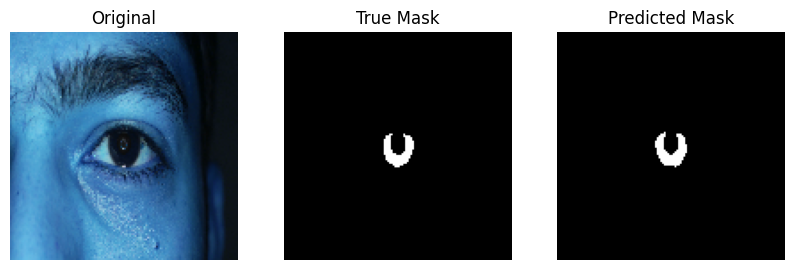

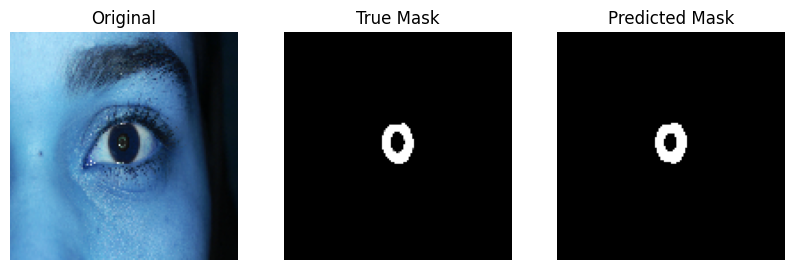

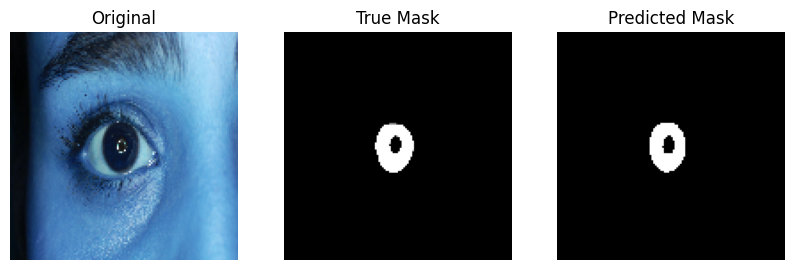

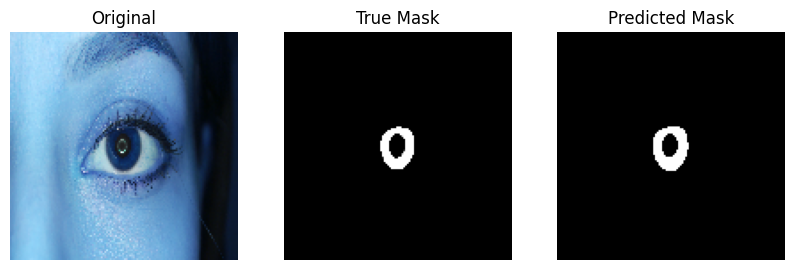

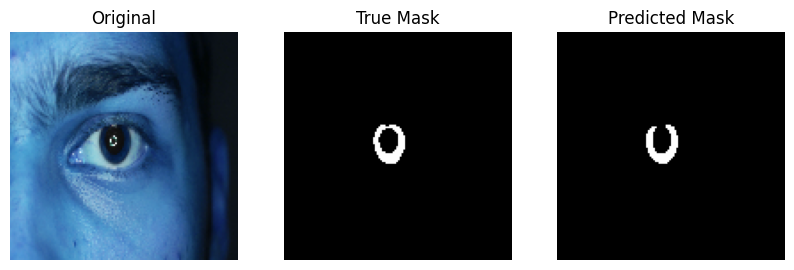

In [10]:
# --------- 8) VISUALIZE PREDICTIONS ---------
def show_predictions(X, Y, model, n=4):
    idxs = np.random.choice(len(X), size=n, replace=False)
    preds = model.predict(X[idxs])
    preds_bin = (preds > 0.5).astype(np.float32)

    for i, idx in enumerate(idxs):
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.imshow(X[idx])
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(Y[idx].squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(preds_bin[i].squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.show()

show_predictions(X_test, y_test, model, n=5)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# Flatten to 1D for classification metrics
y_true_flat = y_test.flatten()
y_pred_flat = y_pred_bin.flatten()


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step


In [13]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure predictions are binary 0/1
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# Flatten
y_true_flat = y_test.flatten().astype(np.uint8)
y_pred_flat = y_pred_bin.flatten().astype(np.uint8)


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step


In [14]:
print("\n=== CLASSIFICATION REPORT (Pixel Level) ===")
print(classification_report(y_true_flat, y_pred_flat, target_names=["Background", "Iris"]))



=== CLASSIFICATION REPORT (Pixel Level) ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00  13269808
        Iris       0.93      0.96      0.94    230608

    accuracy                           1.00  13500416
   macro avg       0.96      0.98      0.97  13500416
weighted avg       1.00      1.00      1.00  13500416



In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt

# ---- 1. Predict on test set ----
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# Flatten
y_true_flat = y_test.flatten().astype(np.uint8)
y_pred_flat = y_pred_bin.flatten().astype(np.uint8)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


In [18]:
# ---- 2. Classification Report ----
print("\n=== CLASSIFICATION REPORT (Pixel Level) ===")
print(classification_report(y_true_flat, y_pred_flat, target_names=["Background", "Iris"]))




=== CLASSIFICATION REPORT (Pixel Level) ===
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00  13269808
        Iris       0.93      0.96      0.94    230608

    accuracy                           1.00  13500416
   macro avg       0.96      0.98      0.97  13500416
weighted avg       1.00      1.00      1.00  13500416



In [19]:
# ---- 3. Metrics ----
precision = precision_score(y_true_flat, y_pred_flat)
recall    = recall_score(y_true_flat, y_pred_flat)
f1        = f1_score(y_true_flat, y_pred_flat)
iou       = jaccard_score(y_true_flat, y_pred_flat)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"IoU      : {iou:.4f}")


Precision: 0.9263
Recall   : 0.9587
F1 Score : 0.9422
IoU      : 0.8907


/tmp/ipython-input-2045425090.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")


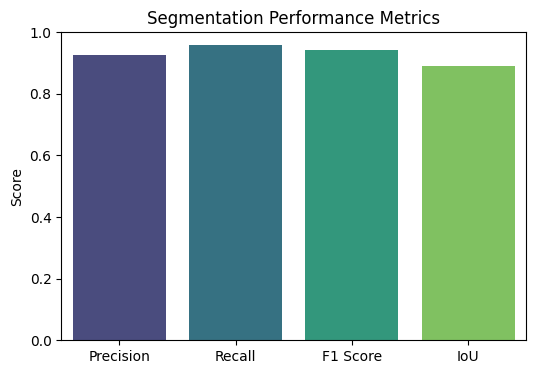

In [20]:
# ---- 4. Bar Plot of Metrics ----
metrics = {"Precision": precision, "Recall": recall, "F1 Score": f1, "IoU": iou}

plt.figure(figsize=(6,4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.ylim(0,1)
plt.title("Segmentation Performance Metrics")
plt.ylabel("Score")
plt.show()

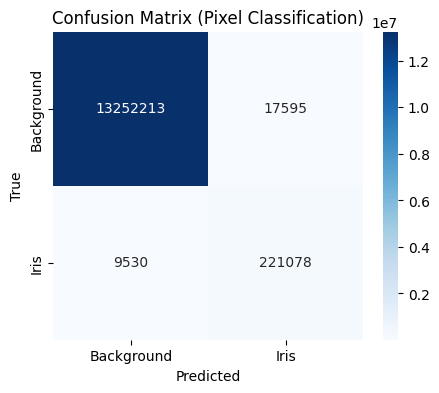

In [21]:
# ---- 5. Confusion Matrix ----
cm = confusion_matrix(y_true_flat, y_pred_flat)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Background","Iris"],
            yticklabels=["Background","Iris"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Pixel Classification)")
plt.show()

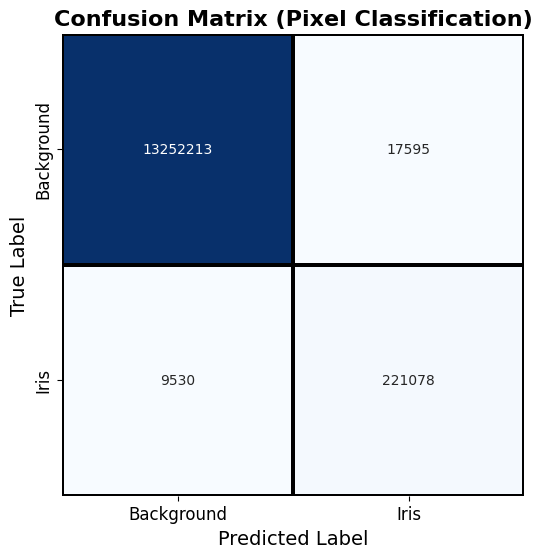

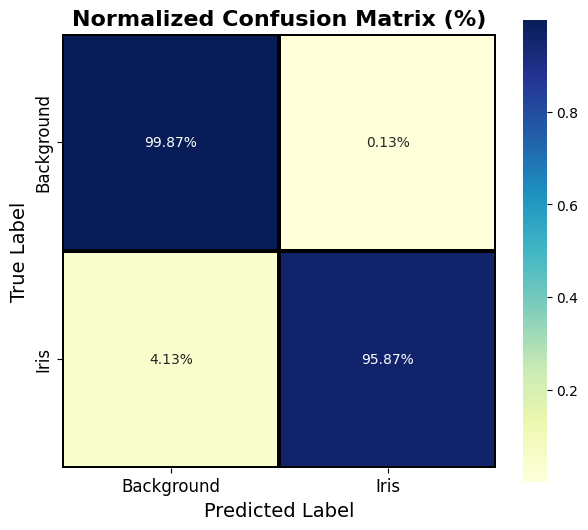

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalized %

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Background","Iris"],
            yticklabels=["Background","Iris"],
            linewidths=1.5, linecolor="black", square=True)

plt.title("Confusion Matrix (Pixel Classification)", fontsize=16, weight="bold")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# --- Normalized version with percentages ---
plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="YlGnBu", cbar=True,
            xticklabels=["Background","Iris"],
            yticklabels=["Background","Iris"],
            linewidths=1.5, linecolor="black", square=True)

plt.title("Normalized Confusion Matrix (%)", fontsize=16, weight="bold")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


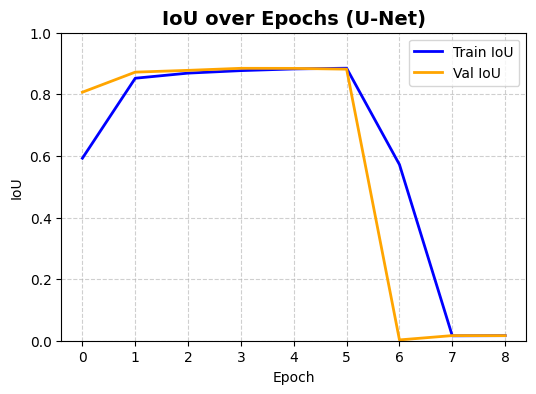

✅ Final Test IoU (U-Net): 0.0168


In [24]:
# ---- Plot IoU Curve ----
plt.figure(figsize=(6,4))
plt.plot(history.history["iou_coef"], label="Train IoU", color="blue", linewidth=2)
plt.plot(history.history["val_iou_coef"], label="Val IoU", color="orange", linewidth=2)
plt.title("IoU over Epochs (U-Net)", fontsize=14, weight="bold")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.ylim(0,1)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# ---- Final IoU on Test Set ----
loss, acc, dice, iou = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Final Test IoU (U-Net): {iou:.4f}")
